In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import matplotlib.pyplot as plt

In [2]:
df = pdr.DataReader(['AAPL', 'BABA', 'BAC', 'AMZN'], 'yahoo', start='2015/01/01', end='2021/12/31')['Adj Close']
df.head()

Symbols,AAPL,BABA,BAC,AMZN
Date,,,,
2015-01-02,24.714508,103.599998,15.647719,308.519989
2015-01-05,24.018263,101.000000,15.193151,302.190002
2015-01-06,24.020521,103.320000,14.738581,295.290009
2015-01-07,24.357342,102.129997,14.808517,298.420013
2015-01-08,25.293201,105.029999,15.114477,300.459991


In [3]:
cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

Symbols,AAPL,BABA,BAC,AMZN
Symbols,,,,
AAPL,0.000335,0.000161,0.000160,0.000193
BABA,0.000161,0.000495,0.000132,0.000181
BAC,0.000160,0.000132,0.000418,0.000110
AMZN,0.000193,0.000181,0.000110,0.000355


In [4]:
corr_matrix = df.pct_change().apply(lambda x: np.log(1+x)).corr()
corr_matrix

Symbols,AAPL,BABA,BAC,AMZN
Symbols,,,,
AAPL,1.000000,0.396080,0.428345,0.561270
BABA,0.396080,1.000000,0.290224,0.432361
BAC,0.428345,0.290224,1.000000,0.285414
AMZN,0.561270,0.432361,0.285414,1.000000


# Portfolio Variance
$$\sigma^2(Rp) = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i w_j COV(R_i, R_j)$$
We use portfolio variance given by the above equation as a measure of a portfolio's risk level.
By modern portfolio theory, we wish to maximize returns for a given risk level.

In [5]:
# Randomly initialize weights
w = {'AAPL': 0.1, 'NKE': 0.2, 'GOOGL': 0.5, 'AMZN': 0.2}
port_var = cov_matrix.mul(w, axis=0).mul(w, axis=1).sum().sum()
port_var

2.5280198036272584e-05

In [6]:
individual_exp_ret = df.resample('Y').last().pct_change().mean()
individual_exp_ret

Symbols
AAPL    0.435779
BABA    0.165691
BAC     0.230372
AMZN    0.328324
dtype: float64

In [7]:
w = [0.1, 0.2, 0.5, 0.2]
port_exp_ret = (w * individual_exp_ret).sum()
port_exp_ret

0.2575669058737473

In [8]:
ann_sd = df.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(250))
ann_sd

Symbols
AAPL    0.289298
BABA    0.351628
BAC     0.323417
AMZN    0.297850
dtype: float64

In [9]:
assets = pd.concat([individual_exp_ret, ann_sd], axis=1) # Creating a table for visualising returns and volatility of assets
assets.columns = ['Returns', 'Volatility']
assets

,Returns,Volatility
Symbols,,
AAPL,0.435779,0.289298
BABA,0.165691,0.351628
BAC,0.230372,0.323417
AMZN,0.328324,0.297850


In [10]:
p_ret = []
p_vol = []
p_weights = []

num_assets = len(df.columns)
num_portfolios = 10000


In [11]:
for i in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights = weights/np.sum(weights)
    p_weights.append(weights)
    returns = np.dot(weights, individual_exp_ret)
    p_ret.append(returns)
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum()
    sd = np.sqrt(var)
    ann_sd = sd*np.sqrt(250)
    p_vol.append(ann_sd)

In [12]:
data = {'Returns':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(df.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in p_weights]

In [13]:
portfolios  = pd.DataFrame(data)
portfolios.head()

,Returns,Volatility,AAPL weight,BABA weight,BAC weight,AMZN weight
0,0.273841,0.235993,0.153820,0.293501,0.237651,0.315027
1,0.279703,0.242805,0.108460,0.062383,0.511778,0.317379
2,0.276481,0.251667,0.133849,0.369596,0.062454,0.434101
3,0.311223,0.233077,0.289896,0.096885,0.331748,0.281471
4,0.290959,0.244026,0.218299,0.062016,0.517969,0.201716


In [14]:
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]                       
min_vol_port

Returns        0.300307
Volatility     0.231648
AAPL weight    0.248113
BABA weight    0.160499
BAC weight     0.291732
AMZN weight    0.299656
Name: 4822, dtype: float64

In [15]:
risk_factor = 0.01
# Sharpe Ratio Computation
optimal_risky_port = portfolios.iloc[((portfolios['Returns'] - risk_factor)/portfolios['Volatility']).idxmax()]
optimal_risky_port

Returns        0.400332
Volatility     0.260400
AAPL weight    0.733125
BABA weight    0.001297
BAC weight     0.066965
AMZN weight    0.198614
Name: 620, dtype: float64

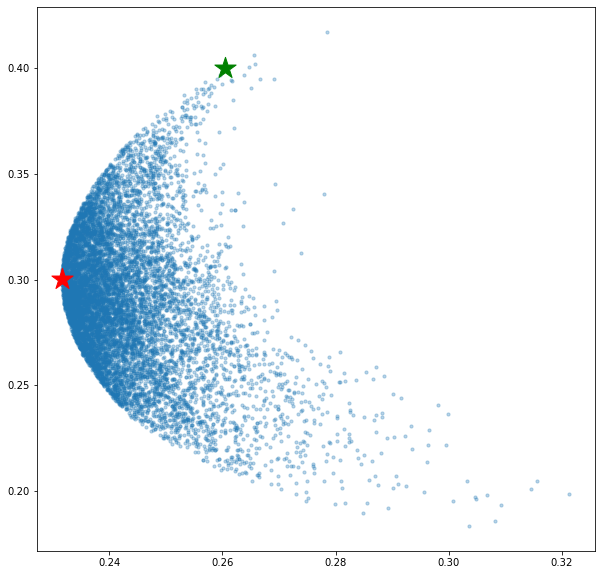

In [16]:
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Returns'],marker='o', s=10, alpha=0.3)
# Red star represents best minimum risk portfolio
plt.scatter(min_vol_port[1], min_vol_port[0], color='r', marker='*', s=500)
# Green star represents optimal risky portfolio (highest sharpe ratio)
plt.scatter(optimal_risky_port[1], optimal_risky_port[0], color='g', marker='*', s=500)

# Conclusions
Our least-risky portfolio had a volatility of 0.231648 and a return of 0.297767. Thus for 3.4% more risk, we can achieve
11% more in returns.